<a href="https://colab.research.google.com/github/ReynaraEzra/Richter-Earthquake-Prediction/blob/main/Richter_Prediction_Part3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Predict Earthquake Damage to Building in Nepal (Part 3)**
## **Reynara Ezra Pratama**

## **Importing Library**

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

from sklearn.model_selection import RandomizedSearchCV

## **Loading Dataset**

In [35]:
url_train_label = 'https://raw.githubusercontent.com/ReynaraEzra/Richter-Earthquake-Prediction/main/train_labels.csv'
url_train_value = 'https://raw.githubusercontent.com/ReynaraEzra/Richter-Earthquake-Prediction/main/train_values.csv'
url_test_value = 'https://raw.githubusercontent.com/ReynaraEzra/Richter-Earthquake-Prediction/main/test_values.csv'

train_label = pd.read_csv(url_train_label)
train_value = pd.read_csv(url_train_value)
test_value = pd.read_csv(url_test_value)

## **Data**

In [36]:
train = pd.merge(train_value, train_label)

In [37]:
train.head()

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,legal_ownership_status,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
0,802906,6,487,12198,2,30,6,5,t,r,n,f,q,t,d,1,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
1,28830,8,900,2812,2,10,8,7,o,r,n,x,q,s,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
2,94947,21,363,8973,2,10,5,5,t,r,n,f,x,t,d,0,1,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3
3,590882,22,418,10694,2,10,6,5,t,r,n,f,x,s,d,0,1,0,0,0,0,1,1,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,2
4,201944,11,131,1488,3,30,8,9,t,r,n,f,x,s,d,1,0,0,0,0,0,0,0,0,0,0,v,1,0,0,0,0,0,0,0,0,0,0,0,3


## **Feature Selection**

In [38]:
corr_matrix = train.corr()
corr_matrix

,building_id,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,1.000000,-0.002850,0.000347,-0.000393,-0.000654,-0.001476,-0.002070,0.000096,-0.000307,0.002423,0.001443,-0.000827,-0.003768,0.001933,0.001967,0.001266,0.002472,-0.002259,0.002171,-0.000599,0.002606,0.002631,0.001934,-0.002152,0.000706,-0.000362,0.002348,-0.000374,0.000538,-0.003116,-0.002295,0.001063
geo_level_1_id,-0.002850,1.000000,-0.061405,0.002718,-0.089364,-0.003908,0.071158,-0.063474,-0.018245,-0.152038,0.007677,0.023656,-0.028854,0.134121,0.144985,0.074169,0.016454,0.015767,0.022670,0.035108,-0.010428,-0.019786,0.001911,0.023523,0.003700,0.002977,0.002655,-0.002303,0.001060,0.000523,-0.017992,-0.072347
geo_level_2_id,0.000347,-0.061405,1.000000,0.000921,0.047730,0.012594,-0.049443,0.035516,0.015833,0.076491,-0.008743,-0.009122,0.014246,-0.079875,-0.023927,-0.032588,-0.038173,-0.036074,-0.020144,-0.012439,-0.001519,0.017522,-0.008439,-0.030704,-0.004840,-0.004856,0.000687,-0.000757,-0.000152,0.001926,-0.013068,0.043161
geo_level_3_id,-0.000393,0.002718,0.000921,1.000000,-0.021646,-0.006385,-0.005643,-0.024507,-0.015732,0.026294,0.019579,0.005966,-0.023278,-0.005116,-0.003916,0.006143,0.002265,-0.012420,-0.010604,-0.002479,0.007375,0.015995,-0.002001,-0.007356,-0.007058,-0.004373,-0.000862,-0.002632,-0.000943,0.000269,-0.002463,0.007932
count_floors_pre_eq,-0.000654,-0.089364,0.047730,-0.021646,1.000000,0.086668,0.101071,0.772734,0.174852,-0.027116,-0.041058,-0.011329,0.257279,-0.085821,-0.056637,-0.070487,0.007448,0.049000,-0.029888,0.086586,0.052125,-0.005294,0.077120,0.035425,0.016384,0.008833,-0.002611,0.006786,0.009639,0.003939,-0.002073,0.122308
age,-0.001476,-0.003908,0.012594,-0.006385,0.086668,1.000000,-0.004323,0.061074,0.068032,0.001321,0.009129,-0.012128,0.079525,-0.036992,0.005855,-0.008374,-0.025431,-0.025552,-0.001520,0.005309,-0.008788,-0.002194,-0.010021,0.001193,-0.004189,-0.003514,-0.003658,-0.002169,-0.001764,-0.001195,-0.004534,0.029273
area_percentage,-0.002070,0.071158,-0.049443,-0.005643,0.101071,-0.004323,1.000000,0.196645,0.026287,-0.225541,-0.000473,0.073701,0.053362,0.210800,-0.053965,-0.031641,0.185047,0.224647,0.007928,0.088630,0.122401,-0.016478,0.159885,0.105983,0.052212,0.050164,0.019421,0.015109,0.015290,0.004983,0.013111,-0.125221
height_percentage,0.000096,-0.063474,0.035516,-0.024507,0.772734,0.061074,0.196645,1.000000,0.149725,-0.106573,-0.020260,0.012960,0.209098,0.001698,-0.052402,-0.063342,0.086228,0.129698,-0.019266,0.064316,0.091780,-0.005390,0.123551,0.068909,0.031366,0.020032,0.001946,0.011192,0.014660,0.004048,0.005397,0.048130
has_superstructure_adobe_mud,-0.000307,-0.018245,0.015833,-0.015732,0.174852,0.068032,0.026287,0.149725,1.000000,-0.306861,0.006962,-0.014554,0.314979,-0.037549,0.011694,0.011528,-0.036830,-0.036782,0.057545,0.033068,-0.013300,-0.003917,-0.012642,-0.003935,-0.004281,-0.002369,0.001762,-0.003292,-0.002648,-0.001493,-0.010074,0.055314
has_superstructure_mud_mortar_stone,0.002423,-0.152038,0.076491,0.026294,-0.027116,0.001321,-0.225541,-0.106573,-0.306861,1.000000,-0.034046,-0.104288,-0.376208,-0.470715,-0.040177,-0.054657,-0.222366,-0.224509,-0.041705,0.001576,-0.087520,0.058261,-0.159532,-0.117948,-0.036064,-0.023070,-0.025507,-0.008763,-0.011904,-0.003380,0.005628

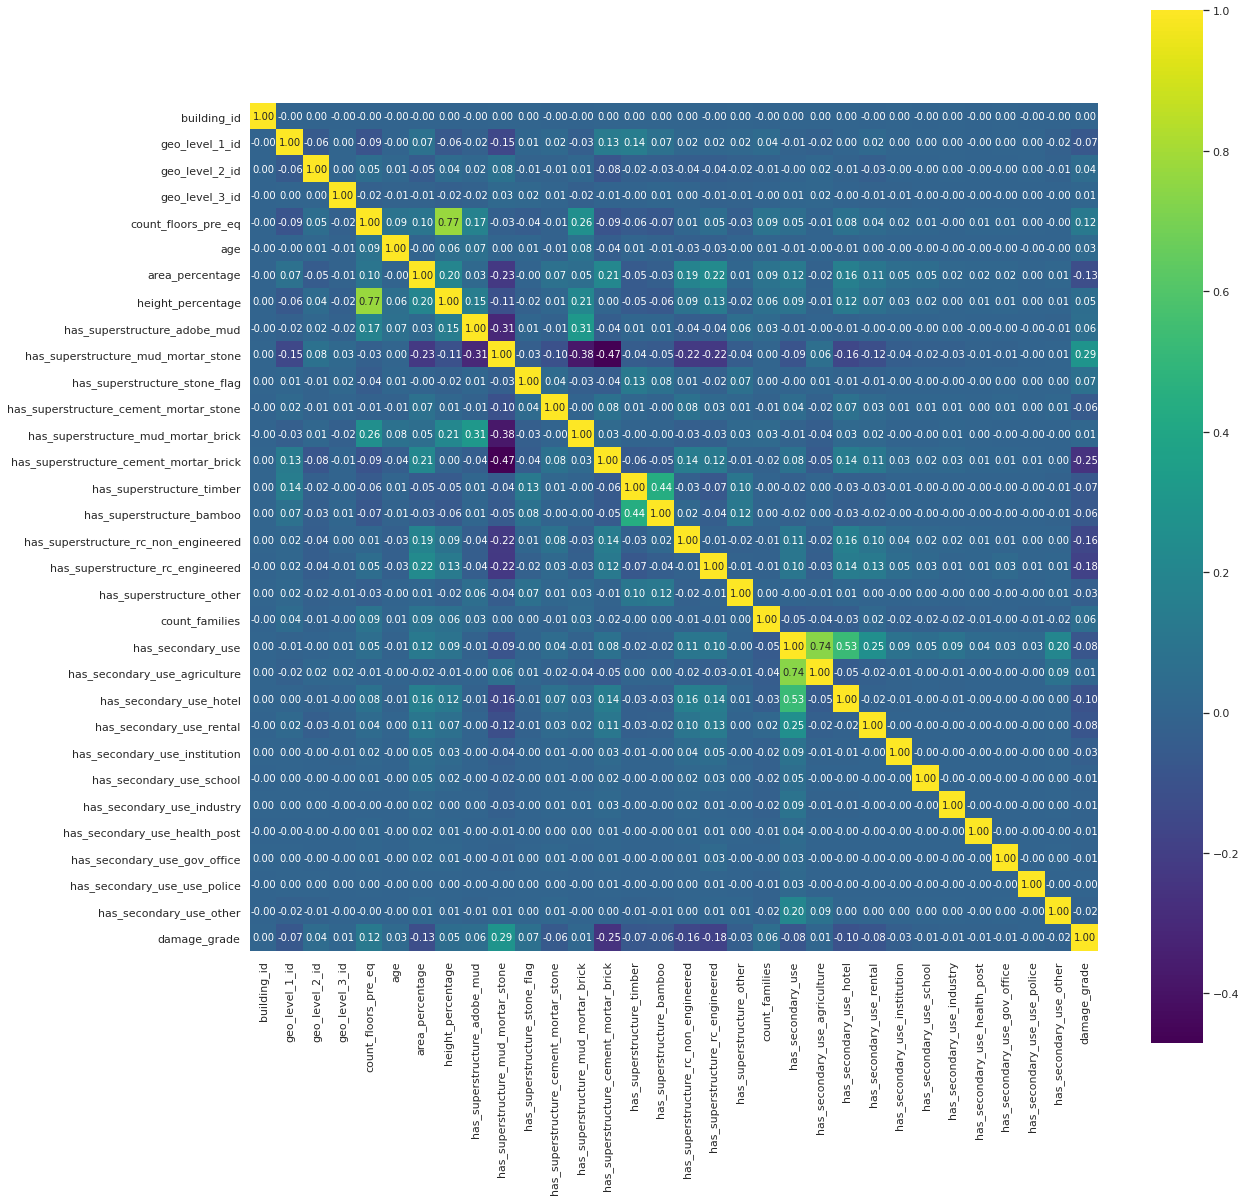

In [39]:
plt.figure(figsize=(19,19))

sns.heatmap(corr_matrix, annot=True, cmap='viridis', square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

Pada gambar di atas, terlihat terdapat feature yang mempunyai korelasi yang tinggi dengan feature lainnya. Feature ***height_percentage*** dan ***has_secondary_use_agriculture*** memiliki tingkat korelasi yang tinggi (> 0,7) dengan feature lain.

In [40]:
target_corr_matrix = corr_matrix['damage_grade'].drop('damage_grade').sort_values(ascending=False)
target_corr_matrix

has_superstructure_mud_mortar_stone       0.291325
count_floors_pre_eq                       0.122308
has_superstructure_stone_flag             0.066039
count_families                            0.056151
has_superstructure_adobe_mud              0.055314
height_percentage                         0.048130
geo_level_2_id                            0.043161
age                                       0.029273
has_superstructure_mud_mortar_brick       0.014561
has_secondary_use_agriculture             0.011309
geo_level_3_id                            0.007932
building_id                               0.001063
has_secondary_use_use_police             -0.001656
has_secondary_use_health_post            -0.008543
has_secondary_use_gov_office             -0.009378
has_secondary_use_industry               -0.011024
has_secondary_use_school                 -0.011692
has_secondary_use_other                  -0.016334
has_secondary_use_institution            -0.028728
has_superstructure_other       

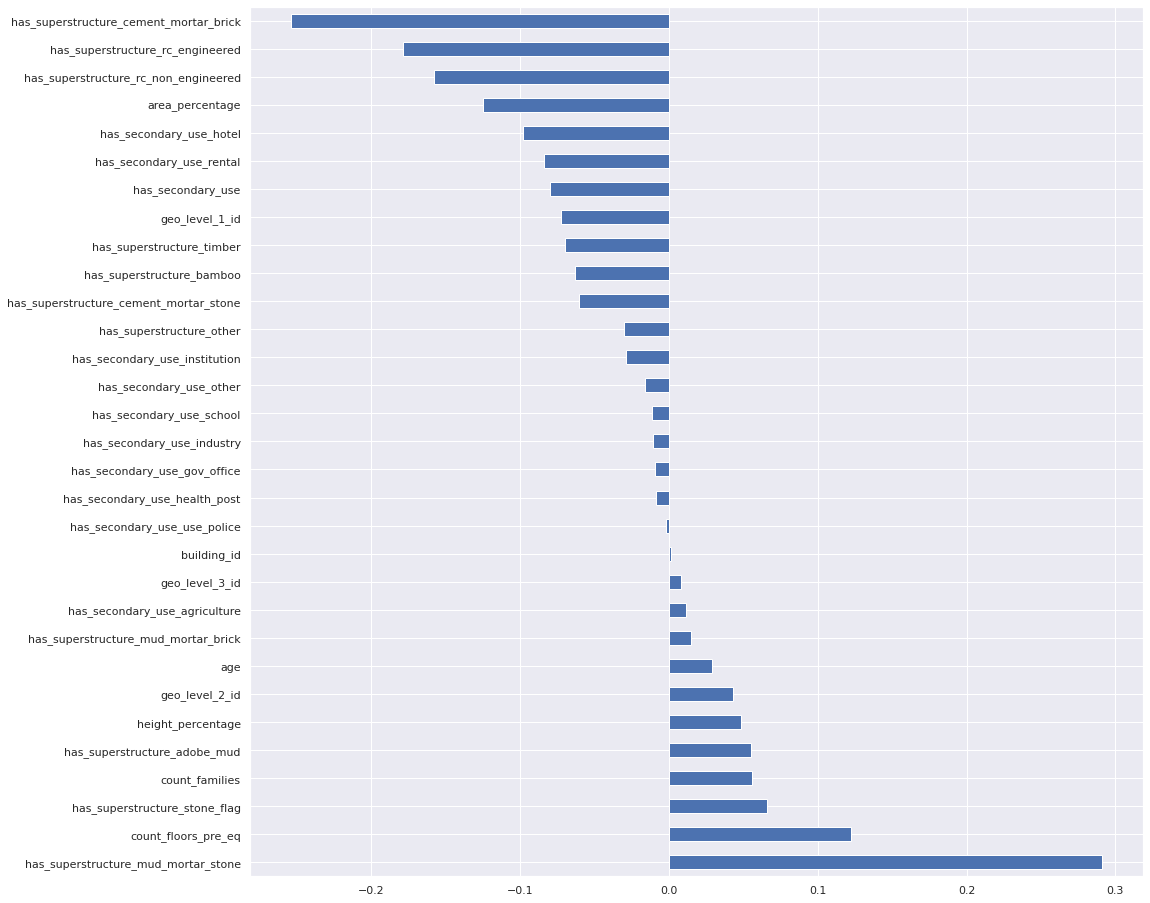

In [41]:
plt.figure(figsize=(16,16))
sns.set_theme()
target_corr_matrix.plot(kind='barh')
plt.show()

In [42]:
df = train.copy()
df = df.set_index('building_id')

**Pisahkan Feature Numerik dan Kategorikal**

In [43]:
df_num = df.select_dtypes(include=['int64', 'float64'])
df_cat = df.select_dtypes(include=['object'])

**Feature Selection Untuk Feature Numerik**

Pada matrik korelasi sebelumnya terlihat bahwa terdapat dua buah feature yang memiliki tingkat korelasi yang tinggi (>0.7). Penggunakan matrik korelasi dapat dilakukan untuk mengecek multicollinearity. Multicollinearity dapat menimbulkan masalah seperti redudansi dimana dua feature tersebut dapat menyimpan informasi yang serupa/mirip. Dalam mengatasi multicollinearity, kita dapat membuang dua buah feature tersebut atau salah satu agar tidak ada feature yang mempunyai tingkat korelasi yang tinggi dengan feature lain. Akan dicek antara feature ***height_percentage*** dan ***has_secondary_use_agriculture*** yang mempunyai tingkat korelasi lebih tinggi terhadap target ***damage_grade***.

In [44]:
print('Korelasi feature height_percentange dengan damage_grade : {:.4f}'.format(target_corr_matrix['height_percentage']))
print('Korelasi feature has_secondary_use_agriculture dengan damage_grade : {:.4f}'.format(target_corr_matrix['has_secondary_use_agriculture']))

Korelasi feature height_percentange dengan damage_grade : 0.0481
Korelasi feature has_secondary_use_agriculture dengan damage_grade : 0.0113


Berdasarkan nilai korelasi di atas, terlihat bahwa feature ***height_percentage*** mempunyai tingkat korelasi yang lebih tinggi, maka kita akan membuang feature ***has_secondary_use_agriculture***.

In [45]:
df_num.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_agriculture,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,6,487,12198,2,30,6,5,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
28830,8,900,2812,2,10,8,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
94947,21,363,8973,2,10,5,5,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3
590882,22,418,10694,2,10,6,5,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2
201944,11,131,1488,3,30,8,9,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,3


In [46]:
df_num = df_num.drop('has_secondary_use_agriculture', axis=1)

In [47]:
df_num.shape

(260601, 30)

**Feature Selection Untuk Feature Kategorikal**

Proses pemilihan feature yang bertipe kategorikal akan menggunakan *SelectKBest*. Menggunakan hal ini, digunakan metrics *chi squared* yang mana jika *chi squared* semakin tinggi, maka semakin signifikan pengaruh dari feature tersebut.

In [48]:
df_cat.head()

,land_surface_condition,foundation_type,roof_type,ground_floor_type,other_floor_type,position,plan_configuration,legal_ownership_status
building_id,,,,,,,,
802906,t,r,n,f,q,t,d,v
28830,o,r,n,x,q,s,d,v
94947,t,r,n,f,x,t,d,v
590882,t,r,n,f,x,s,d,v
201944,t,r,n,f,x,s,d,v


In [49]:
df_cat = pd.get_dummies(df_cat)

In [50]:
df_cat.head()

,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
28830,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
94947,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
590882,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
201944,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [51]:
df_cat.shape

(260601, 38)

In [52]:
category_rank_feature = SelectKBest(score_func=chi2, k=38)
rank_feature = category_rank_feature.fit(df_cat, df_num['damage_grade'])
rank_feature.scores_

array([3.14202700e+02, 6.77046429e+01, 6.77640172e+01, 4.15860728e+02,
       2.79293047e+04, 6.39195232e+03, 5.49424844e+03, 8.31579458e+03,
       1.04584801e+03, 1.15697625e+03, 2.80485950e+04, 3.68489235e+03,
       9.75543604e+01, 3.24654211e+04, 6.05516649e+01, 1.22429528e+02,
       7.42291993e+03, 5.10846128e+03, 1.85494082e+04, 4.06602490e+02,
       2.59354872e+02, 1.48779877e+02, 4.93714399e+01, 6.22421247e+02,
       1.09200110e+02, 1.50572497e+02, 3.04753264e+01, 3.34305427e+00,
       1.36435198e+01, 1.65187836e+00, 5.72019260e+01, 3.23110604e+02,
       3.31565900e+01, 1.01176162e+03, 2.26362245e+03, 5.34417037e+01,
       3.96056239e+01, 2.29493063e+02])

In [53]:
cat_score = pd.DataFrame(rank_feature.scores_, columns=['Score'])
cat_col = pd.DataFrame(df_cat.columns, columns=['Feature'])
univariate_cat_rank = pd.concat([cat_col, cat_score], axis=1)
univariate_cat_rank.set_index('Feature', inplace=True)
sorted_univariate_cat_rank = univariate_cat_rank.sort_values('Score', ascending=False)
#sorted_univariate_cat_rank

In [54]:
chi2_greater100 = sorted_univariate_cat_rank[sorted_univariate_cat_rank['Score']>100]

**Merge Feature Numerik dan Kategorikal**

In [55]:
df_new = pd.concat([df_num, df_cat], axis=1)

In [56]:
df_new.sample(6)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
517057,7,282,11749,1,15,9,4,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
585497,26,39,11440,2,15,6,6,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
402727,8,1054,6496,3,45,3,7,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
743893,4,605,11025,3,0,7,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,1,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
515787,26,1023,9865,1,10,16,3,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
515357,22,1152,5360,2,35,8,6,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## **Scaling Feature**

In [57]:
standar_scaler = StandardScaler()
scaled_df = df_new.copy()

scaled_col = ['geo_level_1_id', 'geo_level_2_id', 'geo_level_3_id', 
              'count_floors_pre_eq', 'age', 'area_percentage', 
              'height_percentage']

feature_scaled = scaled_df[scaled_col]
feature_scaled = standar_scaler.fit_transform(feature_scaled)
scaled_df[scaled_col] = feature_scaled
data = scaled_df.copy()

In [58]:
data.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,-0.983414,-0.518705,1.629055,-0.178274,0.047100,-0.459460,-0.226419,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
28830,-0.734459,0.481998,-0.945017,-0.178274,-0.224765,-0.004110,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
94947,0.883744,-0.819158,0.744612,-0.178274,-0.224765,-0.687135,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0
590882,1.008221,-0.685893,1.216589,-0.178274,-0.224765,-0.459460,-0.226419,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
201944,-0.361028,-1.381296,-1.308119,1.195989,0.047100,-0.004110,1.858636,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [59]:
data.tail()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
688636,1.381653,1.536007,-1.271644,-1.552536,0.386932,-0.459460,-1.268946,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
669485,0.385835,0.033741,-1.151250,-0.178274,-0.360698,-0.459460,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
602512,0.385835,-1.575137,0.522472,1.195989,0.386932,-0.459460,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
151409,1.506130,-1.604213,-1.208568,-0.178274,-0.224765,1.361941,0.294845,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
747594,0.883744,-1.676903,0.779715,1.195989,-0.224765,-0.231785,0.294845,0,1,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


In [60]:
data.sample(5)

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,damage_grade,land_surface_condition_n,land_surface_condition_o,land_surface_condition_t,foundation_type_h,foundation_type_i,foundation_type_r,foundation_type_u,foundation_type_w,roof_type_n,roof_type_q,roof_type_x,ground_floor_type_f,ground_floor_type_m,ground_floor_type_v,ground_floor_type_x,ground_floor_type_z,other_floor_type_j,other_floor_type_q,other_floor_type_s,other_floor_type_x,position_j,position_o,position_s,position_t,plan_configuration_a,plan_configuration_c,plan_configuration_d,plan_configuration_f,plan_configuration_m,plan_configuration_n,plan_configuration_o,plan_configuration_q,plan_configuration_s,plan_configuration_u,legal_ownership_status_a,legal_ownership_status_r,legal_ownership_status_v,legal_ownership_status_w
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
884560,0.261358,-0.845811,1.612874,-0.178274,-0.020866,-0.004110,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
231108,-0.112073,0.186391,1.059994,-0.178274,-0.224765,1.134266,0.294845,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
168145,-0.983414,-1.361912,-0.591789,-0.178274,0.998629,-0.004110,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0
744836,-0.609982,1.322782,0.593776,-1.552536,-0.224765,-0.004110,-0.747683,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0
837056,-0.734459,-0.576857,-0.338385,-0.178274,-0.360698,-0.459460,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,3,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0


## **Building Model**

In [61]:
y = data['damage_grade']
X = data[list(df_num.columns)+list(chi2_greater100.index)]
X.drop('damage_grade', axis=1, inplace=True)

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((208480, 54), (52121, 54), (208480,), (52121,))

## **Hyperparameter Tuning**

**RandomizedCV**

In [35]:
model_7 = RandomForestClassifier()
model_7.fit(X_train, y_train)
pred_7 = model_7.predict(X_test)
train_pred_7 = model_7.predict(X_train)
print(classification_report(y_test, pred_7))
print(classification_report(y_train, train_pred_7))
score_7 = f1_score(y_test, pred_7, average='micro')
train_7 = f1_score(y_train, train_pred_7, average='micro')
print('F1 Score (Micro) for Random Forest Algorithm is : {}'.format(score_7))
print('Train F1 Score (Micro) for Random Forest Algorithm is : {}'.format(train_7))

              precision    recall  f1-score   support

           1       0.64      0.47      0.54      4979
           2       0.72      0.82      0.77     29703
           3       0.71      0.59      0.65     17439

    accuracy                           0.71     52121
   macro avg       0.69      0.63      0.65     52121
weighted avg       0.71      0.71      0.71     52121

              precision    recall  f1-score   support

           1       0.99      0.98      0.99     20145
           2       0.99      0.99      0.99    118556
           3       0.99      0.98      0.98     69779

    accuracy                           0.99    208480
   macro avg       0.99      0.98      0.99    208480
weighted avg       0.99      0.99      0.99    208480

F1 Score (Micro) for Random Forest Algorithm is : 0.7137238349225838
Train F1 Score (Micro) for Random Forest Algorithm is : 0.9864111665387567


In [39]:
params = {'n_estimators': range(50, 251, 50),
          'max_depth': range(3, 25),
          'max_features': ['sqrt', 'log2', None]}

model = RandomForestClassifier()
kfold = KFold(n_splits=3)
rscv = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=20, 
                          cv=kfold, random_state=0, n_jobs=-1)

rscv.fit(X,y)
print("Optimal hyperparameter combination:", rscv.best_params_)
print()
print("Mean cross-validated training accuracy score:", rscv.best_score_)

Optimal hyperparameter combination: {'n_estimators': 250, 'max_features': None, 'max_depth': 20}

Mean cross-validated training accuracy score: 0.7340723941964921


In [77]:
params = {'n_estimators': range(50, 301, 50),
          'max_depth': range(3, 30),
          'max_features': ['sqrt', 'log2', None]}

model = RandomForestClassifier()
kfold = KFold(n_splits=4)
rscv = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=20, 
                          cv=kfold, random_state=0, n_jobs=-1)

rscv.fit(X,y)
print("Optimal hyperparameter combination:", rscv.best_params_)
print()
print("Mean cross-validated training accuracy score:", rscv.best_score_)

Optimal hyperparameter combination: {'n_estimators': 200, 'max_features': None, 'max_depth': 24}

Mean cross-validated training accuracy score: 0.7314361753726537


In [48]:
model_test = RandomForestClassifier(n_estimators=250, max_features=None, max_depth=20)
model_test.fit(X_train,y_train)
pred_test = model_test.predict(X_test)
train_pred = model_test.predict(X_train)
print(f1_score(y_train, train_pred, average='micro'))
print(f1_score(y_test, pred_test, average='micro'))

0.8814994244052187
0.7370349763051361


In [63]:
final_model = RandomForestClassifier(n_estimators=250, max_features=None, max_depth=20)
final_model.fit(X,y)
pred = final_model.predict(X)
cm = confusion_matrix(y, final_model.predict(X))
print('Confusion matrix: \n',cm)
print(f1_score(y, pred, average='micro'))
print('Classification report: \n',classification_report(y, pred))

Confusion matrix: 
 [[ 19730   5240    154]
 [   604 139003   8652]
 [   135  18538  68545]]
0.872130191365344
Classification report: 
               precision    recall  f1-score   support

           1       0.96      0.79      0.87     25124
           2       0.85      0.94      0.89    148259
           3       0.89      0.79      0.83     87218

    accuracy                           0.87    260601
   macro avg       0.90      0.84      0.86    260601
weighted avg       0.88      0.87      0.87    260601



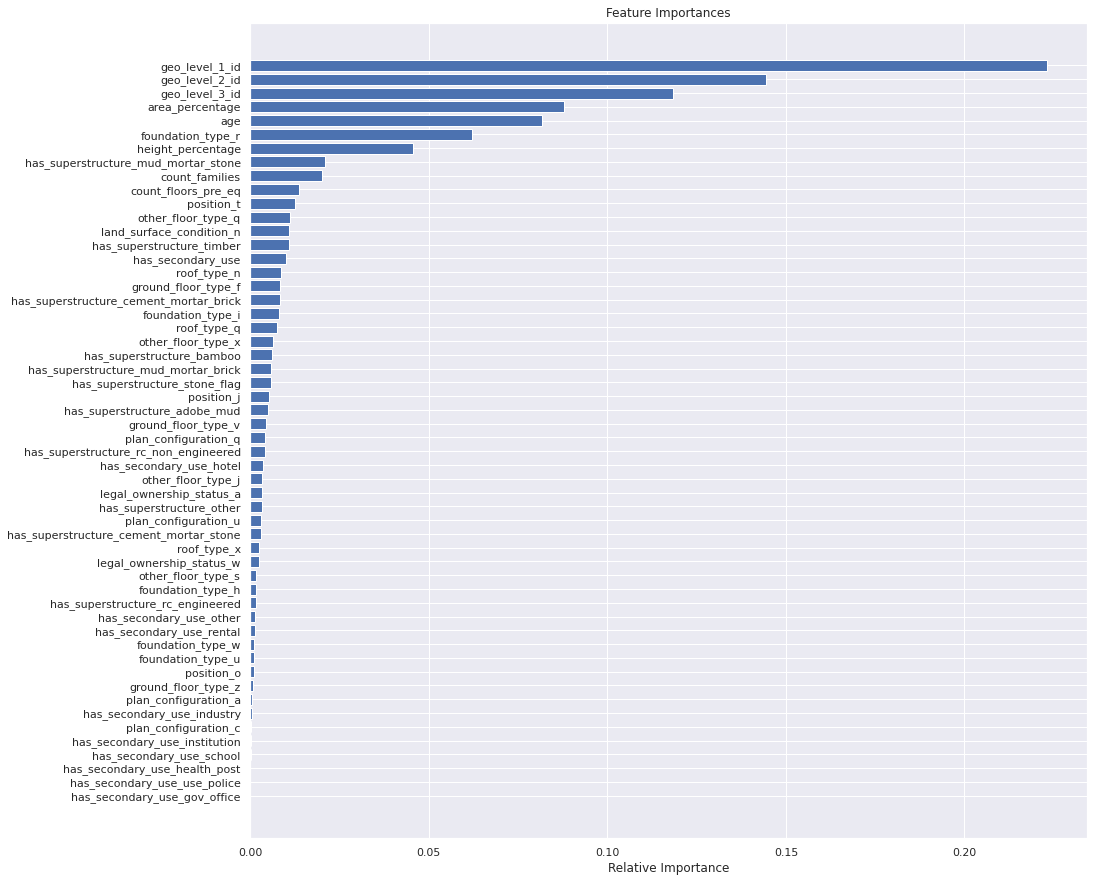

In [72]:
features = X.columns
importances = final_model.feature_importances_
indices = np.argsort(importances)
plt.figure(figsize=(15,15))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), features[indices])
plt.xlabel('Relative Importance')
plt.show()

In [70]:
len(X.columns)

54

In [73]:
indices

array([26, 27, 25, 23, 22, 50, 24, 53, 52, 51, 36, 33, 21, 28, 16, 44, 32,
       49, 30, 10, 42, 17, 39, 34, 20, 15, 46, 29,  7, 48,  9, 11, 14, 45,
       40, 31, 12, 38, 41, 19, 13, 47, 37, 43,  3, 18,  8,  6, 35,  4,  5,
        2,  1,  0])

In [75]:
importances

array([2.23214285e-01, 1.44321792e-01, 1.18402228e-01, 1.36592159e-02,
       8.18255432e-02, 8.79206269e-02, 4.55369079e-02, 4.96533799e-03,
       2.09059448e-02, 5.84952135e-03, 2.89003381e-03, 5.93234291e-03,
       8.42594940e-03, 1.08760699e-02, 6.18690432e-03, 4.04158455e-03,
       1.49262984e-03, 3.33413842e-03, 2.02380021e-02, 1.00913008e-02,
       3.44508766e-03, 1.41873919e-03, 2.96611664e-04, 1.18824513e-04,
       3.90447577e-04, 5.74411900e-05, 2.34248959e-05, 3.77887173e-05,
       1.42998221e-03, 4.36455959e-03, 2.53099879e-03, 8.18063345e-03,
       1.60758575e-03, 1.06543367e-03, 3.38396347e-03, 6.22258273e-02,
       1.00496006e-03, 1.12734886e-02, 8.46175655e-03, 3.37491728e-03,
       7.60240886e-03, 8.63006020e-03, 3.04952196e-03, 1.26172121e-02,
       1.60145837e-03, 6.35725231e-03, 4.10150951e-03, 1.09937147e-02,
       5.36050831e-03, 2.34677682e-03, 3.55213042e-04, 9.29755645e-04,
       8.31875234e-04, 4.19901272e-04])

In [74]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,ground_floor_type_v,roof_type_x,foundation_type_i,other_floor_type_s,foundation_type_w,other_floor_type_j,foundation_type_r,foundation_type_u,other_floor_type_q,ground_floor_type_f,legal_ownership_status_a,roof_type_q,roof_type_n,plan_configuration_u,position_t,foundation_type_h,other_floor_type_x,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,plan_configuration_a
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,-0.983414,-0.518705,1.629055,-0.178274,0.047100,-0.459460,-0.226419,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
28830,-0.734459,0.481998,-0.945017,-0.178274,-0.224765,-0.004110,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
94947,0.883744,-0.819158,0.744612,-0.178274,-0.224765,-0.687135,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
590882,1.008221,-0.685893,1.216589,-0.178274,-0.224765,-0.459460,-0.226419,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
201944,-0.361028,-1.381296,-1.308119,1.195989,0.047100,-0.004110,1.858636,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0


## **Predict on Unseen Data**

In [ ]:
X.head()

,geo_level_1_id,geo_level_2_id,geo_level_3_id,count_floors_pre_eq,age,area_percentage,height_percentage,has_superstructure_adobe_mud,has_superstructure_mud_mortar_stone,has_superstructure_stone_flag,has_superstructure_cement_mortar_stone,has_superstructure_mud_mortar_brick,has_superstructure_cement_mortar_brick,has_superstructure_timber,has_superstructure_bamboo,has_superstructure_rc_non_engineered,has_superstructure_rc_engineered,has_superstructure_other,count_families,has_secondary_use,has_secondary_use_hotel,has_secondary_use_rental,has_secondary_use_institution,has_secondary_use_school,has_secondary_use_industry,has_secondary_use_health_post,has_secondary_use_gov_office,has_secondary_use_use_police,has_secondary_use_other,ground_floor_type_v,roof_type_x,foundation_type_i,other_floor_type_s,foundation_type_w,other_floor_type_j,foundation_type_r,foundation_type_u,other_floor_type_q,ground_floor_type_f,legal_ownership_status_a,roof_type_q,roof_type_n,plan_configuration_u,position_t,foundation_type_h,other_floor_type_x,plan_configuration_q,land_surface_condition_n,position_j,legal_ownership_status_w,plan_configuration_c,position_o,ground_floor_type_z,plan_configuration_a
building_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
802906,-0.983414,-0.518705,1.629055,-0.178274,0.047100,-0.459460,-0.226419,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0
28830,-0.734459,0.481998,-0.945017,-0.178274,-0.224765,-0.004110,0.816109,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
94947,0.883744,-0.819158,0.744612,-0.178274,-0.224765,-0.687135,-0.226419,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0
590882,1.008221,-0.685893,1.216589,-0.178274,-0.224765,-0.459460,-0.226419,0,1,0,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
201944,-0.361028,-1.381296,-1.308119,1.195989,0.047100,-0.004110,1.858636,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0
